# Random Forest

In [1]:
import pandas as pd
import numpy as np
import nltk
import re

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import TweetTokenizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [2]:
#Additional imports to "translate" emoji
from transformers import AutoTokenizer
import emoji

In [3]:
df = pd.read_csv("data/stock_tweets.csv")
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,XPEV,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",XPEV,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,XPEV,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",XPEV,XPeng Inc.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80793 entries, 0 to 80792
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          80793 non-null  object
 1   Tweet         80793 non-null  object
 2   Stock Name    80793 non-null  object
 3   Company Name  80793 non-null  object
dtypes: object(4)
memory usage: 2.5+ MB


In [5]:
df["Stock Name"].value_counts()

Stock Name
TSLA    37422
TSM     11034
AAPL     5056
PG       4089
AMZN     4089
MSFT     4089
NIO      3021
META     2751
AMD      2227
NFLX     1727
GOOG     1291
PYPL      843
DIS       635
BA        399
COST      393
INTC      315
KO        310
CRM       233
XPEV      225
ENPH      216
ZS        193
VZ        123
BX         50
NOC        31
F          31
Name: count, dtype: int64

MAMAA: 1, MAMMA: 0

In [6]:
df["Stock Name"] = df["Stock Name"].replace({"TSLA": 0, "TSM": 0, "AAPL": 1, "PG": 0, "AMZN": 1, "MSFT": 1, "NIO": 0, "META": 1, "AMD": 0,
"NFLX": 0, "GOOG": 1, "PYPL": 0, "DIS": 0, "BA": 0, "COST": 0, "INTC": 0, "KO": 0, "CRM": 0, "XPEV": 0, "ENPH": 0, "ZS": 0, "VZ": 0, 
"BX": 0, "NOC": 0, "NVDA": 0, "F": 0}, regex=True)
df

,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,0,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,0,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,0,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",0,"Tesla, Inc."
...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,0,XPeng Inc.
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",0,XPeng Inc.
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,0,XPeng Inc.
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",0,XPeng Inc.


In [7]:
df["Stock Name"].value_counts()

Stock Name
0    63517
1    17276
Name: count, dtype: int64

In [8]:
def emojidescription(text):
  return emoji.replace_emoji(text, replace=lambda chars, data_dict: " ".join(data_dict["en"].split("_")).strip(":"))

In [9]:
df["EmojiToken"] = df["Tweet"].apply(emojidescription)
df

,Date,Tweet,Stock Name,Company Name,EmojiToken
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,0,"Tesla, Inc.",Mainstream media has done an amazing job at br...
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,0,"Tesla, Inc.",Tesla delivery estimates are at around 364k fr...
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,0,"Tesla, Inc.",3/ Even if I include 63.0M unvested RSUs as of...
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,0,"Tesla, Inc.",@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",0,"Tesla, Inc.","@RealDanODowd @Tesla Stop trying to kill kids,..."
...,...,...,...,...,...
80788,2021-10-07 17:11:57+00:00,Some of the fastest growing tech stocks on the...,0,XPeng Inc.,Some of the fastest growing tech stocks on the...
80789,2021-10-04 17:05:59+00:00,"With earnings on the horizon, here is a quick ...",0,XPeng Inc.,"With earnings on the horizon, here is a quick ..."
80790,2021-10-01 04:43:41+00:00,Our record delivery results are a testimony of...,0,XPeng Inc.,Our record delivery results are a testimony of...
80791,2021-10-01 00:03:32+00:00,"We delivered 10,412 Smart EVs in Sep 2021, rea...",0,XPeng Inc.,"We delivered 10,412 Smart EVs in Sep 2021, rea..."


Building from the classification notebook.

In [10]:
#Added these stop words after the initial normalization step
addstopwords = ["@", "amp"]

stopwords = nltk.corpus.stopwords.words("english")
stopwords.extend(addstopwords)
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [11]:
def clean(tweets):
    retext = re.sub("((www.[^s]+)|(https?://[^s]+))", " ", tweets)

    tokenizer = TweetTokenizer(reduce_len=True, strip_handles=True)
    tokens = tokenizer.tokenize(retext)

    stoptokens = [token.lower() for token in tokens if ((token.isalpha()) & (token.lower() not in stopwords))]

    stemmer = SnowballStemmer(language="english")
    stems = [stemmer.stem(word) for word in stoptokens]
    return stems

In [12]:
df["TweetNorm"] = df["EmojiToken"].apply(clean)
df.sample(20)

,Date,Tweet,Stock Name,Company Name,EmojiToken,TweetNorm
78093,2022-05-14 20:15:36+00:00,George Soros' fund bought 101 MILLION shares o...,0,NIO Inc.,George Soros' fund bought 101 MILLION shares o...,"[georg, soro, fund, bought, million, share, ni..."
38488,2022-06-05 20:37:25+00:00,$AMZN I Amazon previously split its stock more...,1,Microsoft Corporation,$AMZN I Amazon previously split its stock more...,"[amzn, amazon, previous, split, stock, year, a..."
902,2022-09-17 09:25:43+00:00,"*TESLA: 10,000 MODEL Y CARS BUILT AT GIGA TEXA...",0,"Tesla, Inc.","*TESLA: 10,000 MODEL Y CARS BUILT AT GIGA TEXA...","[tesla, model, car, built, giga, texa, date, t..."
11592,2022-05-17 18:33:42+00:00,This is very interesting as Elon is basically ...,0,"Tesla, Inc.",This is very interesting as Elon is basically ...,"[interest, elon, basic, claim, fraud, issu, de..."
17580,2022-03-27 17:33:07+00:00,Hey @Tesla your service center says this is no...,0,"Tesla, Inc.",Hey @Tesla your service center says this is no...,"[hey, servic, center, say, normal, behavior, m..."
34162,2021-10-26 14:30:49+00:00,$TSLA is a $1.1 trillion company with no Gener...,0,"Tesla, Inc.",$TSLA is a $1.1 trillion company with no Gener...,"[tsla, trillion, compani, general, counsel]"
58478,2022-04-20 21:17:52+00:00,With $NFLX and $FB destroyed I think we need t...,1,Apple Inc.,With $NFLX and $FB destroyed I think we need t...,"[nflx, fb, destroy, think, need, offici, repla..."
52920,2022-05-02 18:56:15+00:00,$GOOG's EV/EBIT (17x) is a 9 year low; \n(not ...,1,Alphabet Inc.,$GOOG's EV/EBIT (17x) is a 9 year low; \n(not ...,"[ev, ebit, year, low, compar, interest, observ..."
76888,2021-12-20 00:03:00+00:00,#LT's Weekly Watchlist for 12/20 - 12/23 🎅\n\n...,0,"PayPal Holdings, Inc.",#LT's Weekly Watchlist for 12/20 - 12/23 Santa...,"[week, watchlist, santa, claus, crwd, arrow, r..."
76084,2021-12-15 02:29:59+00:00,"Update on Apple, Nvidia, Tesla, AMD, ROKU, Pal...",0,The Boeing Company,"Update on Apple, Nvidia, Tesla, AMD, ROKU, Pal...","[updat, appl, nvidia, tesla, amd, roku, palant..."


In [13]:
df["TweetNorm"] = df["TweetNorm"].apply(" ".join)

In [14]:
df_class = df.filter(["Stock Name", "TweetNorm"], axis=1)
df_class

,Stock Name,TweetNorm
0,0,mainstream media done amaz job brainwash peopl...
1,0,tesla deliveri estim around analyst tsla
2,0,even includ unvest rsus addit equiti need rsus...
3,0,hahaha still tri stop tesla fsd bro get shit t...
4,0,stop tri kill kid sad derang old man
...,...,...
80788,0,fastest grow tech stock market mix upst xpev a...
80789,0,earn horizon quick snapshot largest increas co...
80790,0,record deliveri result testimoni unwav pursuit...
80791,0,deliv smart ev sep reach mileston unit month d...


In [15]:
X = df_class["TweetNorm"]
y = df_class["Stock Name"]

In [16]:
df_class["TweetNorm"]

0        mainstream media done amaz job brainwash peopl...
1                 tesla deliveri estim around analyst tsla
2        even includ unvest rsus addit equiti need rsus...
3        hahaha still tri stop tesla fsd bro get shit t...
4                     stop tri kill kid sad derang old man
                               ...                        
80788    fastest grow tech stock market mix upst xpev a...
80789    earn horizon quick snapshot largest increas co...
80790    record deliveri result testimoni unwav pursuit...
80791    deliv smart ev sep reach mileston unit month d...
80792    xpeng deliv outstand perform extrem condit ceo...
Name: TweetNorm, Length: 80793, dtype: object

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=59)

Creating a pipeline:

In [18]:
countvector = [("countvector", CountVectorizer(min_df=0.05, max_df=0.95))]
pipeline = Pipeline(countvector)

In [19]:
X_tr_proc = pipeline.fit_transform(X_train)

In [20]:
featurenames = pipeline["countvector"].get_feature_names_out()
pd.DataFrame(X_tr_proc.toarray(), columns=featurenames)

,aapl,amd,amzn,buy,day,face,fb,get,go,like,...,nflx,nvda,share,stock,tesla,today,tsla,tsm,week,year
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
56551,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
56552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
class_priors = y_train.value_counts()/y_train.shape[0]
class_priors

Stock Name
0    0.785908
1    0.214092
Name: count, dtype: float64

In [22]:
bow = pd.DataFrame(X_tr_proc.toarray(), columns=featurenames)
bow

,aapl,amd,amzn,buy,day,face,fb,get,go,like,...,nflx,nvda,share,stock,tesla,today,tsla,tsm,week,year
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0,1,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
56551,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
56552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
56553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [23]:
#The Please Don't GridSearch Code
forest = RandomForestClassifier(n_estimators=200, criterion="entropy", random_state=51)
forest.fit(bow, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200, random_state=51)

In [24]:
X_transform = pipeline.fit_transform(X_test)

In [25]:
y_pred = forest.predict(X_transform)

/Users/xi/anaconda3/envs/kris_data/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [26]:
roc_auc_score(y_test, y_pred)

0.8174433223044965

/Users/xi/anaconda3/envs/kris_data/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


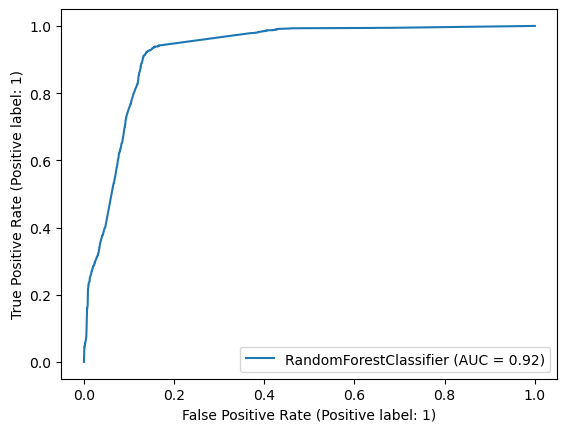

In [27]:
RocCurveDisplay.from_estimator(forest, X_transform, y_test);

In [28]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     18678
           1       0.73      0.68      0.70      5560

    accuracy                           0.87     24238
   macro avg       0.82      0.80      0.81     24238
weighted avg       0.87      0.87      0.87     24238



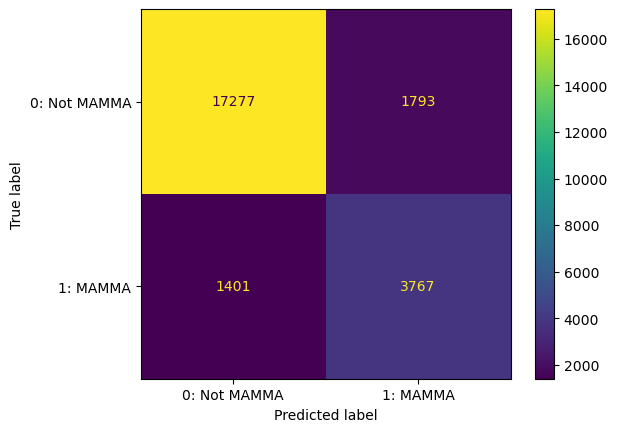

In [29]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["0: Not MAMMA", "1: MAMMA"]);

Predicts with 87% accuracy and a false positive rate of ~7%. This is the best model as it had an increase in 1% accuracy compared to the best NB model.
